# Notebook Configuration

In [1]:
import torch
import torchvision.transforms as transforms
#Import VGG19
from torchvision.models import resnet18, vgg19, resnet50
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import json
import numpy as np
#TEst change
%cd /app/

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/app


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
#Read information json:
PATH_JSON_INFO = '/Datasets/PICAI_olmos/info-12x32x32.json'
PATH_PICAI_folds = "/Datasets/PICAI_olmos/picai_folds_indexes.json"
PATH_SLICES = '/Datasets/PICAI_32x32x12/slices/' # Format -> idPatient_000i_sj.npy
                                                 # Where i = [0,1,2] and j = [1,2,3]
with open(PATH_PICAI_folds, 'r') as f:
    idxs = json.load(f)

with open(PATH_JSON_INFO, 'r') as f:   # -> case_ISUP is the label
    info = json.load(f)

In [3]:
gpu = "0" #iF YOU WANT TO USE GPU
# gpu = None 

#----------------------------------------------------------------
# Selecting the device
#----------------------------------------------------------------
if gpu:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = gpu #aca se pone nuemro de grafica libre

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Using GPU: {torch.cuda.get_device_name()}')
    print('CUDA Visible devices:',os.getenv('CUDA_VISIBLE_DEVICES'))
else:
    device = torch.device('cpu')
    print("Failed to find GPU, using CPU instead.")
#

Using GPU: NVIDIA GeForce GTX 750 Ti
CUDA Visible devices: 0


/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:184: UserWarning: 
    Found GPU0 NVIDIA GeForce GTX 750 Ti which is of cuda capability 5.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 5.2.
    
  warnings.warn(


# Loading Dataset

The dataset consist on slices that where previously standarized by volume

In [4]:
idxs_train = idxs["Fold_0_train"]
idxs_val = idxs["Fold_0_val"]

In [5]:
# Load pretrained CNN model
cnn_model = vgg19(pretrained=True)#.to(device)
cnn_model = torch.nn.Sequential(*list(cnn_model.children())[0][:5])#.to(device)  # Remove the fully connected layers
cnn_model.eval()
#summary(cnn_model, (3, 32, 32))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [6]:
def compute_features_per_slice(index,slice_idx):
    """"
    Parameters:
    index: int
        Index of the patient
    slice_idx: int
        Index of the slice
    
    The function gets the 3 modalities of the slice and returns the features of each one
    """
    feat_list = []
    for modality in ['0000','0001','0002']:
        slice_path = os.path.join(PATH_SLICES, f'{index}_{modality}_s{slice_idx}.npy')
        slice = np.load(slice_path)
        #Repeat over the first axis to have 3 channels and convert it to tensor
        slice = torch.tensor(np.repeat(slice[:, :, np.newaxis], 3, axis=2)).permute(2, 0, 1).float()
        features = cnn_model(slice.unsqueeze(0))
        feat_list.append(features)
    
    #concatenate the features of the 3 modalities on the channel axis
    features = torch.cat(feat_list, dim=1)
    return features
    

In [7]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import sys

def create_graph_from_features(features):
    G = nx.Graph()
    num_nodes = features.shape[0]
    # Add nodes, each node feature is the feature vector of the corresponding image

    for i in range(num_nodes):
        G.add_node(i, feature=features[i,:])
    
    # Compute similarity and add edges
    similarity_matrix = cosine_similarity(features)

    #Define the threshold to preserve 25% of the similarity matrix
    threshold = np.percentile(similarity_matrix, 90)

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if similarity_matrix[i, j] > threshold:  # Threshold can be adjusted
                G.add_edge(i, j, weight=similarity_matrix[i, j])
    
    #If a node has no connections drop the node and the row and column on similarity matrices
    nodes_to_remove = []
    for node in G.nodes:
        if G.degree(node) == 0:
            nodes_to_remove.append(node)
    
    G.remove_nodes_from(nodes_to_remove)

    return G


In [8]:
import sys

def compute_graphs(indexes):
    graphs = []
    labels = []
    total = len(indexes)
    i = 0
    for key in indexes:
        for slice_idx in range(3):
            features_si = compute_features_per_slice(key,slice_idx)
            #Squeeze the first axis
            features_si = features_si.squeeze(0)
            #Vectorize the last 2 axis
            features_si = features_si.view(features_si.shape[0], -1).cpu().detach().numpy()
            graph = create_graph_from_features(features_si)

            graphs.append(graph)
            labels.append(info[key]['case_ISUP'])
        i += 1
        sys.stdout.write(f"\r{round(i/total*100,3)}%")
        break
    return graphs, labels

print("Train")
graphs_train, labels_train = compute_graphs(idxs_train)
print("")
print("Test")
graphs_val, labels_val = compute_graphs(idxs_val)

Train
0.097%
Test
0.385%

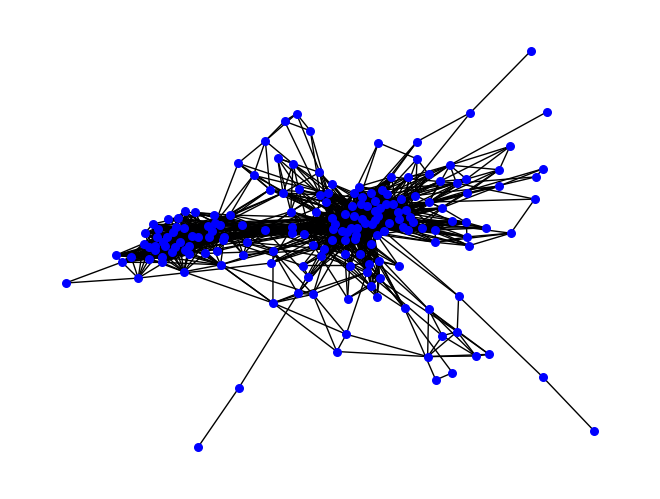

185


In [9]:
#Plot the graph

import matplotlib.pyplot as plt
i=0
def plot_graph(graph):
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=False, node_size=30, node_color='blue')
    plt.show()

plot_graph(graphs_train[i])
print(len(graphs_train[i].nodes))

In [10]:
#Check the dimension of one node feature
print(len(graphs_train[i].nodes[0]['feature']))

256


In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataListLoader, DataLoader

In [12]:


#Convert all the labels to binary -- > 0,1
labels_train = [0 if label == 0 else 1 for label in labels_train]
labels_val = [0 if label == 0 else 1 for label in labels_val]

# Prepare data for GNN
train_data_list = []

for graph, label in zip(graphs_train, labels_train):
    x = torch.tensor(np.array([graph.nodes[node]['feature'] for node in graph.nodes]), dtype=torch.float)
    #print(x.shape)
    edge_index = torch.tensor(list(graph.edges)).t()#.contiguous()
    y = torch.tensor([label])  # Replace with actual class labels
    data = Data(x=x, edge_index=edge_index, y=y)
    train_data_list.append(data)
    break
    #print(edge_index.t().shape)
train_loader = DataLoader(train_data_list, batch_size=16, shuffle=True)

test_data_list = []

for graph, label in zip(graphs_val, labels_val):
    x = torch.tensor(np.array([graph.nodes[node]['feature'] for node in graph.nodes]), dtype=torch.float)
    edge_index = torch.tensor(list(graph.edges)).t()#.contiguous()
    y = torch.tensor([label])  # Replace with actual class labels
    data = Data(x=x, edge_index=edge_index, y=y)
    test_data_list.append(data)
    break

test_loader = DataLoader(test_data_list, batch_size=16, shuffle=False)


In [13]:
for data in train_loader:
    print(data.y)
    break

tensor([0])


In [14]:
from torch import Tensor
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 128, add_self_loops=False)
        self.conv2 = GCNConv(128, 64, add_self_loops=False)
        self.conv3 = GCNConv(64, out_channels, add_self_loops=False)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        # x: Node feature matrix of shape [num_nodes, in_channels]
        # edge_index: Graph connectivity matrix of shape [2, num_edges]
        print(x.shape)
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index)
        return x

model = GCN(data.num_features, 1)

In [15]:
# Training the GNN

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(2):  # Number of epochs can be adjusted
    total_loss = 0
    for data in train_loader:
        #print(data.y)
        x, edge_index, y = data.x, data.edge_index, data.y
        #x.to(device), edge_index.to(device), y.to(device)
        #print(x.shape)
        #break
        optimizer.zero_grad()
        edge_index = data.edge_index
        print(x.shape, edge_index.shape, y.shape)
        out = model(x, edge_index)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    #break
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')

torch.Size([185, 256]) torch.Size([2, 1749]) torch.Size([1])
torch.Size([185, 256])
tensor(0) tensor(189)


RuntimeError: index 186 is out of bounds for dimension 0 with size 185